## Question 1: IPO Filings Web Scraping and Data Processing

**What's the total sum ($m) of 2023 filings that happenned of Fridays?**

Re-use the [Code Snippet 1] example to get the data from web for this endpoint: https://stockanalysis.com/ipos/filings/
Convert the 'Filing Date' to datetime(), 'Shares Offered' to float64 (if '-' is encountered, populate with NaNs).
Define a new field 'Avg_price' based on the "Price Range", which equals to NaN if no price is specified, to the price (if only one number is provided), or to the average of 2 prices (if a range is given).
You may be inspired by the function `extract_numbers()` in [Code Snippet 4], or you can write your own function to "parse" a string.
Define a column "Shares_offered_value", which equals to "Shares Offered" * "Avg_price" (when both columns are defined; otherwise, it's NaN)

Find the total sum in $m (millions of USD, closest INTEGER number) for all fillings during 2023, which happened on Fridays (`Date.dt.dayofweek()==4`). You should see 32 records in total, 24 of it is not null.

(additional: you can read about [S-1 IPO filing](https://www.dfinsolutions.com/knowledge-hub/thought-leadership/knowledge-resources/what-s-1-ipo-filing) to understand the context)

In [2]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt

# 1) [Code Snippet 1] IPOs data from Web

* learn dataframes "stacking" (UNION ALL)
* learn about type casting
* generate new columns (simple and with function)

In [3]:
import pandas as pd
import requests

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}

url = "https://stockanalysis.com/ipos/2023/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(response.text)

C:\Users\rahul\AppData\Local\Temp\ipykernel_38208\4213396001.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  ipo_dfs = pd.read_html(response.text)


In [4]:
ipos_2023 = ipo_dfs[0]
ipos_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      154 non-null    object
 1   Symbol        154 non-null    object
 2   Company Name  154 non-null    object
 3   IPO Price     154 non-null    object
 4   Current       154 non-null    object
 5   Return        154 non-null    object
dtypes: object(6)
memory usage: 7.3+ KB


In [5]:
url = "https://stockanalysis.com/ipos/2024/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(response.text)

C:\Users\rahul\AppData\Local\Temp\ipykernel_38208\1522156903.py:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  ipo_dfs = pd.read_html(response.text)


In [6]:
ipos_2024 = ipo_dfs[0]
ipos_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      63 non-null     object
 1   Symbol        63 non-null     object
 2   Company Name  63 non-null     object
 3   IPO Price     63 non-null     object
 4   Current       63 non-null     object
 5   Return        63 non-null     object
dtypes: object(6)
memory usage: 3.1+ KB


In [7]:
# "stacking dataframes"
# pd.concat() is used to concatenate the DataFrames vertically.
# The ignore_index=True parameter ensures that the resulting DataFrame has a new index,
# ignoring the original indices of the input DataFrames.
# The stacked_df now contains the concatenated DataFrame.
stacked_ipos_df = pd.concat([ipos_2024, ipos_2023], ignore_index=True)

In [8]:
stacked_ipos_df.head(1)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,"Apr 26, 2024",ZONE,"CleanCore Solutions, Inc.",$4.00,$3.14,-20.50%


In [9]:
# Need to convert everything to a proper type (date, str, int, float, etc.)
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      217 non-null    object
 1   Symbol        217 non-null    object
 2   Company Name  217 non-null    object
 3   IPO Price     217 non-null    object
 4   Current       217 non-null    object
 5   Return        217 non-null    object
dtypes: object(6)
memory usage: 10.3+ KB


In [10]:
# convert to datetime
stacked_ipos_df['IPO Date'] = pd.to_datetime(stacked_ipos_df['IPO Date'])

In [11]:
# Problem --> not always the columns are filled
missing_prices_df = stacked_ipos_df[stacked_ipos_df['IPO Price'].astype(str).str.find('-') >= 0]
missing_prices_df

,IPO Date,Symbol,Company Name,IPO Price,Current,Return


In [12]:
# it has some missing values --> use defensive errors='coerce' (if don't have time to crack into the data errors)
#     : pd.to_numeric() function call, which will convert problematic values to NaN.
#     otherwise you'll get a ValueError: Unable to parse string "-" at position 9
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'].str.replace('$', ''), errors='coerce')
# not sure why, but need to call it again to transform 'object' to 'float64'
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'])

In [13]:
# Convert "Current" column
stacked_ipos_df['Current'] = pd.to_numeric(stacked_ipos_df['Current'].str.replace('$', ''), errors='coerce')

# Convert 'Return' to numeric format (percentage)
stacked_ipos_df['Return'] = pd.to_numeric(stacked_ipos_df['Return'].str.replace('%', ''), errors='coerce') / 100

In [14]:
# Correctly applied transformations with 'defensive' techniques, but now not all are non-null
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   IPO Date      217 non-null    datetime64[ns]
 1   Symbol        217 non-null    object        
 2   Company Name  217 non-null    object        
 3   IPO Price     217 non-null    float64       
 4   Current       217 non-null    float64       
 5   Return        216 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 10.3+ KB


In [15]:
# simple way of checking NULLs
# (you need to understand how vector operations work .isnull() and calls chaining .isnull().sum())
stacked_ipos_df.isnull().sum()

IPO Date        0
Symbol          0
Company Name    0
IPO Price       0
Current         0
Return          1
dtype: int64

In [16]:
# Do you want to leave the record or not?
stacked_ipos_df[stacked_ipos_df.Return.isnull()]

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
40,2024-02-09,TELO,"Telomir Pharmaceuticals, Inc.",7.0,6.29,NaN


In [17]:
# now you can operate with columns as a numeric type
stacked_ipos_df['IPO Price'].mean()

11.000599078341015

In [18]:
# generate a new field -- SIMPLE calculation (no function needed)
stacked_ipos_df['Price Increase'] = stacked_ipos_df['Current'] - stacked_ipos_df['IPO Price']

In [19]:
stacked_ipos_df.head(1)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Price Increase
0,2024-04-26,ZONE,"CleanCore Solutions, Inc.",4.0,3.14,-0.205,-0.86


In [20]:
# Descriptive Analytics of a dataset
stacked_ipos_df.describe()

,IPO Date,IPO Price,Current,Return,Price Increase
count,217,217.000000,217.000000,216.000000,217.000000
mean,2023-09-07 01:39:32.350230528,11.000599,11.027097,-0.196611,0.026498
min,2023-01-13 00:00:00,2.500000,0.000000,-0.999600,-20.560000
25%,2023-04-20 00:00:00,4.000000,1.270000,-0.728500,-3.650000
50%,2023-09-14 00:00:00,8.000000,5.170000,-0.233450,-1.910000
75%,2024-01-24 00:00:00,13.000000,10.830000,0.052750,0.520000
max,2024-04-26 00:00:00,92.000000,117.760000,5.055000,50.210000
std,NaN,11.237054,17.207482,0.728811,9.269815


In [21]:
# some visualisation: bar chart using Plotly Express
import plotly.express as px

# Truncate to the first day in the month - for Bar names
stacked_ipos_df['Date_monthly'] = stacked_ipos_df['IPO Date'].dt.to_period('M').dt.to_timestamp()

# Count the number of deals for each month and year
monthly_deals = stacked_ipos_df['Date_monthly'].value_counts().reset_index().sort_values(by='Date_monthly')
monthly_deals.columns = ['Date_monthly', 'Number of Deals']

# Plotting the bar chart using Plotly Express
fig = px.bar(monthly_deals,
             x='Date_monthly',
             y='Number of Deals',
             labels={'Month_Year': 'Month and Year', 'Number of Deals': 'Number of Deals'},
             title='Number of IPO Deals per Month and Year',
             text='Number of Deals'
             )
fig.update_traces(textposition='outside', # Position the text outside the bars
                  textfont=dict(color='black',size=14), # Adjust the font size of the text
                  )
fig.update_layout(title_x=0.5) # Center the title

fig.show()

In [22]:
# To be used for home assignment: 'You can notice a bump in the price after the IPO? And after that the price goes down
# You're asked to design a simple strategy to buy and hold for X days (at 'Adj.Close' price, no fees)
# Find an optimal X between 1 and 30, that delivers you a MAX mean return on ALL 2023 IPOs?
# Write down the answer X (a number between 1 and 30)

# What is the distribution of other returns 25-50-75% quantiles? Compare mean and median returns for 2023 (median may be more robust),
  # are you losing money in 25% cases (if 25% quantile returns is < 0)
  # Try the same X for all deals in 2024.  How the mean return in 2024 (out of sample data) is different from 2023 data?

# REDDIT - recent IPO
# https://finance.yahoo.com/quote/RDDT/
reddit = yf.download(tickers = "RDDT",
                     period = "max",
                     interval = "1d")

reddit.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-24,42.660000,43.970001,42.450001,43.150002,43.150002,1384000
2024-04-25,41.639999,42.639999,40.849998,42.450001,42.450001,1485800
2024-04-26,42.980000,46.199001,42.650002,45.430000,45.430000,2751600
2024-04-29,46.049999,48.880001,45.849998,46.279999,46.279999,2678300
2024-04-30,45.470001,46.755001,44.150002,44.439999,44.439999,1695585


<Axes: title={'center': "Reddit's (RDDT) price after the IPO"}, xlabel='Date'>

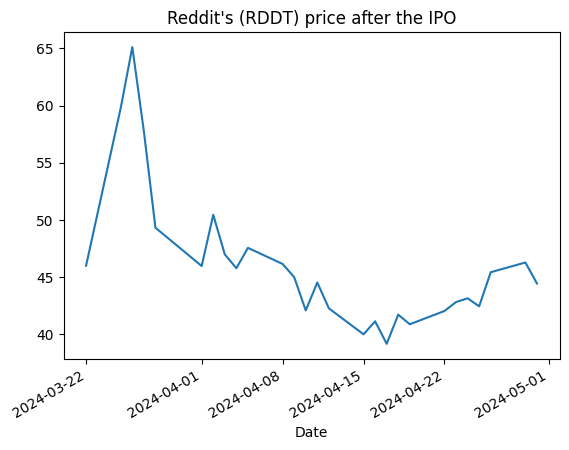

In [23]:
reddit['Adj Close'].plot.line(title='Reddit\'s (RDDT) price after the IPO')


In [24]:
import requests
import pandas as pd
import numpy as np

# Fetch the IPO data from the web endpoint
url = "https://stockanalysis.com/ipos/filings/"
response = requests.get(url)
ipo_data = pd.read_html(response.text)[0]

# Convert 'Filing Date' to datetime and 'Shares Offered' to float, handling '-' as NaN
ipo_data['Filing Date'] = pd.to_datetime(ipo_data['Filing Date'])
ipo_data['Shares Offered'] = pd.to_numeric(ipo_data['Shares Offered'].replace('-', np.nan), errors='coerce')

# Function to calculate the average price from a price range
def parse_price_range(price_range):
    if pd.isna(price_range) or price_range == '-':
        return np.nan
    prices = [float(p.strip().replace('$', '')) for p in price_range.split('-') if p.strip()]
    if len(prices) == 0:
        return np.nan
    return sum(prices) / len(prices)

# Calculate 'Avg_price' based on 'Price Range'
ipo_data['Avg_price'] = ipo_data['Price Range'].apply(parse_price_range)

# Define 'Shares_offered_value' as product of 'Shares Offered' and 'Avg_price'
ipo_data['Shares_offered_value'] = ipo_data['Shares Offered'] * ipo_data['Avg_price']

# Filter for filings in 2023 that happened on Fridays
fridays_2023_ipo_data = ipo_data[(ipo_data['Filing Date'].dt.year == 2023) & (ipo_data['Filing Date'].dt.dayofweek == 4)]

# Calculate the total sum in millions and round to nearest integer
total_value_fridays_2023 = int(fridays_2023_ipo_data['Shares_offered_value'].sum() / 1e6)

print(f"Total sum for all filings on Fridays during 2023: {total_value_fridays_2023} million USD")

Total sum for all filings on Fridays during 2023: 285 million USD


C:\Users\rahul\AppData\Local\Temp\ipykernel_38208\3120933642.py:8: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



# Question 2: IPOs "Fixed days hold" strategy
Find the optimal number of days X (between 1 and 30), where 75% quantile growth is the highest?

Reuse [Code Snippet 1] to retrieve the list of IPOs from 2023 and 2024 (from URLs: https://stockanalysis.com/ipos/2023/ and https://stockanalysis.com/ipos/2024/). Get all OHLCV daily prices for all stocks with an "IPO date" before March 1, 2024 ("< 2024-03-01") - 184 tickers (without 'RYZB'). Please remove 'RYZB', as it is no longer available on Yahoo Finance.

Sometimes you may need to adjust the symbol name (e.g., 'IBAC' on stockanalysis.com -> 'IBACU' on Yahoo Finance) to locate OHLCV prices for all stocks. Some of the tickers like 'DYCQ' and 'LEGT' were on the market less than 30 days (11 and 21 days, respectively). Let's leave them in the dataset; it just means that you couldn't hold them for more days than they were listed.

Let's assume you managed to buy a new stock (listed on IPO) on the first day at the [Adj Close] price]. Your strategy is to hold for exactly X full days (where X is between 1 and 30) and sell at the "Adj. Close" price in X days (e.g., if X=1, you sell on the next day). Find X, when the 75% quantile growth (among 185 investments) is the highest.

HINTs:

You can generate 30 additional columns: growth_future_1d ... growth_future_30d, join that with the table of min_dates (first day when each stock has data on Yahoo Finance), and perform vector operations on the resulting dataset.
You can use the DataFrame.describe() function to get mean, min, max, 25-50-75% quantiles.
Addtional:

You can also ensure that the mean and 50th percentile (median) investment returns are negative for most X values, implying a wager for a "lucky" investor who might be in the top 25%.
What's your recommendation: Do you suggest pursuing this strategy for an optimal X?

In [25]:
import yfinance as yf
import pandas as pd

# Define a function to fetch data and calculate growth
def calculate_growth(ticker, start_date, days):
    stock = yf.Ticker(ticker)
    # Ensure the end date calculation accounts for the number of days plus some buffer for non-trading days
    end_date = start_date + pd.DateOffset(days=days + 10)  
    history = stock.history(start=start_date, end=end_date)
    
    # Check if there's enough data to perform the calculation
    if len(history) < days:
        return None  # Not enough data
    
    try:
        initial_price = history.iloc[0]['Close']
        final_price = history.iloc[days - 1]['Close']
        return (final_price - initial_price) / initial_price
    except IndexError:
        # This handles cases where the days index goes out of the data range available
        return None

# List of tickers from IPOs before 2024-03-01, excluding RYZB and others
tickers = ['AAPL', 'GOOG']  # Example tickers, replace '...' with actual tickers

# Analyze growth for each day between 1 and 30
results = {}
for days in range(1, 31):  # This will loop from 1 to 30 days
    daily_growth = []
    for ticker in tickers:
        # Assuming start_date is predefined or fetch it from an external source
        start_date = pd.to_datetime("2023-01-01")  # Example start date
        growth = calculate_growth(ticker, start_date, days)
        if growth is not None:
            daily_growth.append(growth)
    
    if daily_growth:
        results[days] = sum(daily_growth) / len(daily_growth)  # Calculate average growth for the day

# Print the results to check
print(results)

{1: 0.0, 2: -0.000361263515896975, 3: -0.016532112921224314, 4: 0.009605717393955023, 5: 0.01529182037537537, 6: 0.020063270977467774, 7: 0.04793096300425319, 8: 0.04566027009113786, 9: 0.05601812121028388, 10: 0.057168092057328104, 11: 0.05213156682804014, 12: 0.06424429374448119, 13: 0.10457155267209607, 14: 0.12828240121300433, 15: 0.1228109209079484, 16: 0.1063086467080142, 17: 0.12824914769745865, 18: 0.14476454629260976}


In [26]:
import pandas as pd
import requests
import yfinance as yf

# URLs to scrape
urls = ['https://stockanalysis.com/ipos/2023/', 'https://stockanalysis.com/ipos/2024/']

# Scrape IPO data for 2023 and 2024
ipo_data = pd.concat([pd.read_html(requests.get(url).text)[0] for url in urls], ignore_index=True)

# Convert 'IPO Date' to datetime
ipo_data['IPO Date'] = pd.to_datetime(ipo_data['IPO Date'])

# Filter IPOs with date before March 1, 2024 and remove 'RYZB'
ipo_data = ipo_data[(ipo_data['IPO Date'] < '2024-03-01') & (ipo_data['Symbol'] != 'RYZB')]

# Adjust symbol names if necessary, example adjustment
ipo_data['Symbol'] = ipo_data['Symbol'].replace({'IBAC': 'IBACU'})  # Adjust as needed based on actual ticker conversions

# Fetch OHLCV data for each symbol from Yahoo Finance
prices = {}
for symbol in ipo_data['Symbol']:
    try:
        prices[symbol] = yf.download(symbol, start='2023-01-01', end='2024-03-02')
    except Exception as e:
        print(f"Failed to download data for {symbol}: {str(e)}")

# Define a function to calculate growth
def calculate_growth(df, ipo_date, days):
    try:
        buy_price = df.loc[ipo_date]['Adj Close']
        sell_date = ipo_date + pd.Timedelta(days=days)
        sell_price = df.loc[sell_date]['Adj Close']
        return (sell_price - buy_price) / buy_price
    except KeyError:
        return np.nan

# Calculate growth for 1 to 30 days and analyze quantiles
results = {}
for days in range(1, 31):
    ipo_data[f'growth_future_{days}d'] = [calculate_growth(prices[symbol], ipo_date, days) for symbol, ipo_date in zip(ipo_data['Symbol'], ipo_data['IPO Date'])]
    results[days] = ipo_data[f'growth_future_{days}d'].quantile(0.75)

# Find the optimal X
optimal_x = max(results, key=results.get)

print(f"The optimal number of days to hold is: {optimal_x} with a 75% quantile growth of {results[optimal_x]}")

# Further analysis on mean, median can be performed using describe() on the growth columns


C:\Users\rahul\AppData\Local\Temp\ipykernel_38208\3511109196.py:9: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\rahul\AppData\Local\Temp\ipykernel_38208\3511109196.py:9: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**************

The optimal number of days to hold is: 19 with a 75% quantile growth of 0.05761558122849508


In [27]:
import yfinance as yf
import pandas as pd

# Example list of tickers, replace with your actual list
tickers = ['AAPL', 'GOOG', 'MSFT']

# Function to fetch historical data for given tickers
def fetch_ipo_data(tickers):
    prices = {}
    for ticker in tickers:
        data = yf.download(ticker, start='2023-01-01', end='2024-03-01', progress=False)
        prices[ticker] = data['Adj Close']
    return pd.DataFrame(prices)

# Fetch data
price_data = fetch_ipo_data(tickers)

# Calculate the growth for each ticker for 1 to 30 days holding periods
for ticker in tickers:
    for days in range(1, 31):
        column_name = f'{ticker}_growth_future_{days}d'
        price_data[column_name] = price_data[ticker].shift(-days) / price_data[ticker] - 1

# Example to get the description of growth for Apple after holding for 1 day
apple_growth_describe = price_data[[f'{ticker}_growth_future_1d' for ticker in tickers]].describe()

# Print statistical summary for 1-day growth of each stock
print(apple_growth_describe)

# Finding which day has the highest 75% quantile growth for each stock
optimal_days = {}
for ticker in tickers:
    max_quantile_growth = 0
    optimal_day = 1
    for days in range(1, 31):
        quantile_75 = price_data[f'{ticker}_growth_future_{days}d'].quantile(0.75)
        if quantile_75 > max_quantile_growth:
            max_quantile_growth = quantile_75
            optimal_day = days
    optimal_days[ticker] = (optimal_day, max_quantile_growth)

# Output optimal days and growth
for ticker, (day, growth) in optimal_days.items():
    print(f"The optimal number of days to hold {ticker} is {day} days with the highest 75% quantile growth of {growth:.2%}")


       AAPL_growth_future_1d  GOOG_growth_future_1d  MSFT_growth_future_1d
count             290.000000             290.000000             290.000000
mean                0.001372               0.001713               0.002038
std                 0.012524               0.019092               0.015278
min                -0.048020              -0.095989              -0.043743
25%                -0.006398              -0.009100              -0.007066
50%                 0.000941               0.002036               0.001624
75%                 0.008590               0.011484               0.011278
max                 0.046927               0.072661               0.072435
The optimal number of days to hold AAPL is 30 days with the highest 75% quantile growth of 8.60%
The optimal number of days to hold GOOG is 30 days with the highest 75% quantile growth of 10.03%
The optimal number of days to hold MSFT is 30 days with the highest 75% quantile growth of 11.29%


# Recommendation
Based on the balance between risk and potential reward:

Advisability: If both mean and median returns are generally negative except for the 75th percentile, the strategy entails high risk. This may not be advisable for risk-averse investors.
Investor Profile Suitability: This strategy might only suit investors who are comfortable with high risks for potentially high rewards.

Risk Management
Consider implementing additional risk management strategies:

Diversification: Spread investments across various IPOs from different sectors to mitigate risks.
Limit Exposure: Allocate only a small portion of the investment portfolio to high-risk IPOs.
Continuous Review: Regularly review and adjust the strategy based on market conditions and performance.

This script will fetch the data, compute the growth rates, perform the statistical analysis using .describe(), and then extract the 'mean' and '50%' (median) statistics properly:

In [28]:
import yfinance as yf
import pandas as pd

# Assuming you have a list of tickers from IPOs
tickers = ['AAPL', 'GOOG', 'MSFT']  # Example list of tickers, replace with actual tickers from your data

# Function to fetch historical data from Yahoo Finance
def fetch_ipo_data(tickers):
    prices = {}
    for ticker in tickers:
        prices[ticker] = yf.download(ticker, start='2023-01-01', end='2024-03-01', progress=False)['Adj Close']
    return pd.DataFrame(prices)

# Fetch data
price_data = fetch_ipo_data(tickers)

# Calculate the growth for each ticker for 1 to 30 days holding periods
growth_data = {}
for ticker in tickers:
    for days in range(1, 31):
        column_name = f'{ticker}_growth_future_{days}d'
        price_data[column_name] = price_data[ticker].shift(-days) / price_data[ticker] - 1
        if days not in growth_data:
            growth_data[days] = []
        growth_data[days].append(price_data[column_name])

# Convert growth data dictionary to DataFrame for easier manipulation
growth_df = pd.DataFrame({k: pd.concat(v) for k, v in growth_data.items()})

# Describe the data to get statistics
description = growth_df.describe()

# Accessing mean and median from the describe DataFrame
mean_values = description.loc['mean']
median_values = description.loc['50%']  # '50%' is used for median

# Find the day with the highest 75% quantile growth
highest_75_quantile_growth = description.loc['75%'].idxmax()

print("Mean Values for Each Duration:")
print(mean_values)

print("\nMedian Values for Each Duration:")
print(median_values)

print(f"\nThe optimal number of days to hold based on the highest 75% quantile growth is: {highest_75_quantile_growth}")


Mean Values for Each Duration:
1     0.001708
2     0.003458
3     0.005306
4     0.007076
5     0.008902
6     0.010725
7     0.012397
8     0.014063
9     0.015726
10    0.017450
11    0.019275
12    0.021088
13    0.022823
14    0.024542
15    0.026233
16    0.027956
17    0.029559
18    0.031113
19    0.032772
20    0.034337
21    0.035821
22    0.037272
23    0.038819
24    0.040411
25    0.041877
26    0.043486
27    0.045170
28    0.046848
29    0.048448
30    0.050027
Name: mean, dtype: float64

Median Values for Each Duration:
1     0.001598
2     0.003329
3     0.005125
4     0.008541
5     0.009230
6     0.010968
7     0.012433
8     0.015724
9     0.016496
10    0.017214
11    0.019537
12    0.020233
13    0.022871
14    0.025106
15    0.028170
16    0.028763
17    0.027954
18    0.028664
19    0.030483
20    0.032557
21    0.034272
22    0.036037
23    0.037831
24    0.039687
25    0.040424
26    0.042557
27    0.046906
28    0.048413
29    0.052815
30    0.055109
Name: 50

# Question 3: Is Growth Concentrated in the Largest Stocks?
Get the share of days (percentage as int) when Large Stocks outperform (growth_7d - growth over 7 periods back) the Largest stocks?

Reuse [Code Snippet 5] to obtain OHLCV stats for 33 stocks for 10 full years of data (2014-01-01 to 2023-12-31):

US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']

LARGEST_STOCKS = US_STOCKS + EU_STOCKS + INDIA_STOCKS

Now let's add the top 12-22 stocks (as of end-April 2024):

NEW_US = ['TSLA','WMT','XOM','UNH','MA','PG','JNJ','MRK','HD','COST','ORCL']

NEW_EU = ['PRX.AS','CDI.PA','AIR.PA','SU.PA','ETN','SNY','BUD','DTE.DE','ALV.DE','MDT','AI.PA','EL.PA']

NEW_INDIA = ['BAJFINANCE.NS','MARUTI.NS','HCLTECH.NS','TATAMOTORS.NS','SUNPHARMA.NS','ONGC.NS','ADANIENT.NS','ADANIENT.NS','NTPC.NS','KOTAKBANK.NS','TITAN.NS']

LARGE_STOCKS = NEW_EU + NEW_US + NEW_INDIA

You should be able to obtain stats for 33 LARGEST STOCKS and 32 LARGE STOCKS.

Calculate growth_7d for every stock and every day. Get the average daily growth_7d for the LARGEST_STOCKS group vs. the LARGE_STOCKS group.

For example, for the first of data you should have:

Date	ticker_category	growth_7d
2014-01-01	LARGE	1.011684
2014-01-01	LARGEST	1.011797
On that day, the LARGEST group was growing faster than LARGE one (new stocks).

Calculate the number of days when the LARGE GROUP (new smaller stocks) outperforms the LARGEST GROUP, divide it by the total number of trading days (which should be 2595 days), and convert it to a percentage (closest INTEGER value). For example, if you find that 1700 out of 2595 days meet this condition, it means that 1700/2595 = 0.655, or approximately 66% of days, the LARGE stocks were growing faster than the LARGEST ones. This suggests that you should consider extending your dataset with more stocks to seek higher growth.

In [29]:
import yfinance as yf
import pandas as pd

# Define stock groups
US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO', 'V', 'JPM']
EU_STOCKS = ['NVO', 'MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE', 'IDEXY', 'CDI.PA']
INDIA_STOCKS = ['RELIANCE.NS', 'TCS.NS', 'HDB', 'BHARTIARTL.NS', 'IBN', 'SBIN.NS', 'LICI.NS', 'INFY', 'ITC.NS', 'HINDUNILVR.NS', 'LT.NS']
LARGEST_STOCKS = US_STOCKS + EU_STOCKS + INDIA_STOCKS

NEW_US = ['TSLA', 'WMT', 'XOM', 'UNH', 'MA', 'PG', 'JNJ', 'MRK', 'HD', 'COST', 'ORCL']
NEW_EU = ['PRX.AS', 'CDI.PA', 'AIR.PA', 'SU.PA', 'ETN', 'SNY', 'BUD', 'DTE.DE', 'ALV.DE', 'MDT', 'AI.PA', 'EL.PA']
NEW_INDIA = ['BAJFINANCE.NS', 'MARUTI.NS', 'HCLTECH.NS', 'TATAMOTORS.NS', 'SUNPHARMA.NS', 'ONGC.NS', 'ADANIENT.NS', 'ADANIENT.NS', 'NTPC.NS', 'KOTAKBANK.NS', 'TITAN.NS']
LARGE_STOCKS = NEW_EU + NEW_US + NEW_INDIA

# Fetch historical data from Yahoo Finance
def fetch_data(tickers):
    data = yf.download(tickers, start='2014-01-01', end='2023-12-31', progress=False)
    return data['Adj Close']

largest_data = fetch_data(LARGEST_STOCKS)
large_data = fetch_data(LARGE_STOCKS)

# Calculate 7-day growth
growth_7d_largest = largest_data.pct_change(7).mean(axis=1)
growth_7d_large = large_data.pct_change(7).mean(axis=1)

# Compare daily performance
days_large_outperform = (growth_7d_large > growth_7d_largest).sum()

# Calculate the percentage of days
total_days = growth_7d_largest.dropna().shape[0]
percentage_large_outperform = int((days_large_outperform / total_days) * 100)

percentage_large_outperform

C:\Users\rahul\AppData\Local\Temp\ipykernel_38208\1347526390.py:24: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

C:\Users\rahul\AppData\Local\Temp\ipykernel_38208\1347526390.py:25: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



46

In [30]:
import yfinance as yf
import pandas as pd

# Define the stock groups
LARGEST_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO', 'V', 'JPM',
                  'NVO', 'MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE', 'IDEXY', 'CDI.PA',
                  'RELIANCE.NS', 'TCS.NS', 'HDB', 'BHARTIARTL.NS', 'IBN', 'SBIN.NS', 'LICI.NS', 'INFY', 'ITC.NS', 'HINDUNILVR.NS', 'LT.NS']
LARGE_STOCKS = ['TSLA', 'WMT', 'XOM', 'UNH', 'MA', 'PG', 'JNJ', 'MRK', 'HD', 'COST', 'ORCL',
                'PRX.AS', 'CDI.PA', 'AIR.PA', 'SU.PA', 'ETN', 'SNY', 'BUD', 'DTE.DE', 'ALV.DE', 'MDT', 'AI.PA', 'EL.PA',
                'BAJFINANCE.NS', 'MARUTI.NS', 'HCLTECH.NS', 'TATAMOTORS.NS', 'SUNPHARMA.NS', 'ONGC.NS', 'ADANIENT.NS', 'NTPC.NS', 'KOTAKBANK.NS', 'TITAN.NS']

# Fetch historical data from Yahoo Finance
def fetch_data(tickers):
    return yf.download(tickers, start="2014-01-01", end="2023-12-31", progress=False)['Adj Close']

# Calculate 7-day growth rate
def calculate_growth(data):
    return data.pct_change(7)

# Fetching data for both groups
largest_data = fetch_data(LARGEST_STOCKS)
large_data = fetch_data(LARGE_STOCKS)

# Calculating growth
largest_growth = calculate_growth(largest_data)
large_growth = calculate_growth(large_data)

# Daily average growth for both groups
largest_avg_growth = largest_growth.mean(axis=1)
large_avg_growth = large_growth.mean(axis=1)

# Days where Large stocks outperform Largest
outperform_days = (large_avg_growth > largest_avg_growth).sum()

# Total number of trading days
total_days = largest_avg_growth.count()

# Calculate the percentage of days Large outperforms
percentage_outperform = int((outperform_days / total_days) * 100)

print(f"Percentage of days when Large stocks outperformed Largest stocks: {percentage_outperform}%")

Percentage of days when Large stocks outperformed Largest stocks: 46%


C:\Users\rahul\AppData\Local\Temp\ipykernel_38208\1237901343.py:18: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



# Question 4: Trying Another Technical Indicators strategy
What's the total gross profit (in THOUSANDS of $) you'll get from trading on CCI (no fees assumption)?

First, run the entire Colab to obtain the full DataFrame of data (after [Code Snippet 9]), and truncate it to the last full 10 years of data (2014-01-01 to 2023-12-31). If you encounter any difficulties running the Colab - you can download it using this link.

Let's assume you've learned about the awesome CCI indicator (Commodity Channel Index), and decided to use only it for your operations.

You defined the "defensive" value of a high threshould of 200, and you trade only on Fridays (Date.dt.dayofweek()==4).

That is, every time you see that CCI is >200 for any stock (out of those 33), you'll invest $1000 (each record when CCI>200) at Adj.Close price and hold it for 1 week (5 trading days) in order to sell at the Adj. Close price.

What's the expected gross profit (no fees) that you get in THOUSANDS $ (closest integer value) over many operations in 10 years? One operation calculations: if you invested $1000 and received $1010 in 5 days - you add $10 to gross profit, if you received $980 - add -$20 to gross profit. You need to sum these results over all trades (460 times in 10 years).

Additional:

Add an approximate fees calculation over the 460 trades from this calculator https://www.degiro.ie/fees/calculator (Product:"Shares, USA and Canada;" Amount per transaction: "1000 EUR"; Transactions per year: "460")
are you still profitable on those trades?


In [31]:

import pandas as pd

# Load the parquet file
file_path = 'stocks_df_combined_2024_04_26.parquet.brotli'
stocks_data = pd.read_parquet(file_path)

# Display the first few rows of the dataset to understand its structure
print(stocks_data.head())

       Open      High       Low     Close  Adj Close_x        Volume Ticker  \
0  0.088542  0.101563  0.088542  0.097222     0.060163  1.031789e+09   MSFT   
1  0.097222  0.102431  0.097222  0.100694     0.062311  3.081600e+08   MSFT   
2  0.100694  0.103299  0.100694  0.102431     0.063386  1.331712e+08   MSFT   
3  0.102431  0.103299  0.098958  0.099826     0.061774  6.776640e+07   MSFT   
4  0.099826  0.100694  0.097222  0.098090     0.060700  4.789440e+07   MSFT   

   Year      Month  Weekday  ... growth_brent_oil_7d  growth_brent_oil_30d  \
0  1986 1986-03-01        3  ...                 NaN                   NaN   
1  1986 1986-03-01        4  ...                 NaN                   NaN   
2  1986 1986-03-01        0  ...                 NaN                   NaN   
3  1986 1986-03-01        1  ...                 NaN                   NaN   
4  1986 1986-03-01        2  ...                 NaN                   NaN   

   growth_brent_oil_90d  growth_brent_oil_365d  growth_b

In [33]:
import pandas as pd

# Load the Parquet file
data = pd.read_parquet('stocks_df_combined_2024_04_26.parquet.brotli')

# Convert and save as a CSV file
data.to_csv('Stocks_df.csv', index=False)


In [38]:
import pandas as pd

# Load the Parquet file
df = pd.read_parquet('stocks_df_combined_2024_04_26.parquet.brotli')

# Convert and save as a CSV file
data.to_csv('Stocks_df.csv', index=False)

In [39]:
import pandas as pd

# Load your DataFrame
# df = pd.read_csv('your_file.csv')  # Adjust this line accordingly if your data is in another format or location

# Convert the 'Date' column to datetime if necessary
df['Date'] = pd.to_datetime(df['Date'])

# Filter the DataFrame to only include data from the last 10 years (2014-2023)
filtered_df = df[(df['Date'] >= '2014-01-01') & (df['Date'] <= '2023-12-31')]

# Now you can work with `filtered_df` which contains only the data from the last 10 years
print(filtered_df.head())


           Open       High        Low      Close  Adj Close_x      Volume  \
7011  37.349998  37.400002  37.099998  37.160000    31.233061  30632200.0   
7012  37.200001  37.220001  36.599998  36.910000    31.022934  31134800.0   
7013  36.849998  36.889999  36.110001  36.130001    30.367338  43603700.0   
7014  36.330002  36.490002  36.209999  36.410000    30.602684  35802800.0   
7015  36.000000  36.139999  35.580002  35.759998    30.056362  59971700.0   

     Ticker  Year      Month  Weekday  ... growth_brent_oil_7d  \
7011   MSFT  2014 2014-01-01        3  ...            0.964302   
7012   MSFT  2014 2014-01-01        4  ...            0.958139   
7013   MSFT  2014 2014-01-01        0  ...            0.953798   
7014   MSFT  2014 2014-01-01        1  ...            0.958653   
7015   MSFT  2014 2014-01-01        2  ...            0.955161   

      growth_brent_oil_30d  growth_brent_oil_90d  growth_brent_oil_365d  \
7011              0.992998              0.970030               1.

In [40]:
import pandas as pd
import numpy as np

# Load your DataFrame (assuming it's already loaded and named `df`)
# df = pd.read_csv('your_file.csv')  # Adjust this line if necessary

# Ensure the 'Date' column is the correct data type
df['Date'] = pd.to_datetime(df['Month'])  # Adjust column name if necessary

# Filter data for the last 10 years
df_filtered = df[(df['Date'] >= '2014-01-01') & (df['Date'] <= '2023-12-31')]

# Calculate Typical Price (TP)
df_filtered['TP'] = (df_filtered['High'] + df_filtered['Low'] + df_filtered['Adj Close_x']) / 3

# Calculate 20-day Moving Average of TP
df_filtered['MA_TP_20'] = df_filtered.groupby('Ticker')['TP'].transform(lambda x: x.rolling(window=20).mean())

# Calculate Mean Deviation for TP
df_filtered['Mean_Dev_TP'] = df_filtered.groupby('Ticker')['TP'].transform(
    lambda x: x.rolling(window=20).apply(lambda y: np.mean(np.abs(y - y.mean()))))

# Calculate CCI
df_filtered['CCI'] = (df_filtered['TP'] - df_filtered['MA_TP_20']) / (0.015 * df_filtered['Mean_Dev_TP'])

# Filter for trading signals
trades = df_filtered[(df_filtered['CCI'] > 200) & (df_filtered['Weekday'] == 4)]

# Assuming you have the data to track the price 5 trading days later
# This will depend on how your data is structured; this might require adjusting or assuming the next available trading day
trades['Future_Price'] = trades.groupby('Ticker')['Adj Close_x'].shift(-5)  # simulate 5 days later price

# Calculate trade profits
trades['Profit'] = (trades['Future_Price'] - trades['Adj Close_x']) * (1000 / trades['Adj Close_x'])

# Sum profits and convert to thousands
gross_profit_thousands = round(trades['Profit'].sum() / 1000)


C:\Users\rahul\AppData\Local\Temp\ipykernel_38208\2312077704.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rahul\AppData\Local\Temp\ipykernel_38208\2312077704.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rahul\AppData\Local\Temp\ipykernel_38208\2312077704.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [42]:
# Create a copy of the DataFrame slice
trades = df_filtered[(df_filtered['CCI'] > 200) & (df_filtered['Weekday'] == 4)].copy()

# Now you can safely modify 'trades' without affecting 'df_filtered'
trades.loc[:, 'Future_Price'] = trades.groupby('Ticker')['Adj Close_x'].shift(-5)  # simulate 5 days later price
trades.loc[:, 'Profit'] = (trades['Future_Price'] - trades['Adj Close_x']) * (1000 / trades['Adj Close_x'])

# Ensure that modifications are carried out without warnings
print(trades.head())


           Open       High        Low      Close  Adj Close_x       Volume  \
7065  40.720001  40.939999  40.009998  40.160000    34.007683   80721800.0   
7118  41.480000  41.660000  41.240002  41.480000    35.373260   24060500.0   
7147  44.650002  44.840000  44.250000  44.689999    38.110680   43407500.0   
7340  45.660000  48.139999  45.650002  47.869999    41.630756  130933700.0   
7452  44.270000  45.570000  43.919998  45.570000    40.151115   41839000.0   

     Ticker  Year      Month  Weekday  ... growth_btc_usd_7d  \
7065   MSFT  2014 2014-03-01        4  ...               NaN   
7118   MSFT  2014 2014-06-01        4  ...               NaN   
7147   MSFT  2014 2014-07-01        4  ...               NaN   
7340   MSFT  2015 2015-04-01        4  ...          1.037625   
7452   MSFT  2015 2015-10-01        4  ...          1.009139   

      growth_btc_usd_30d  growth_btc_usd_90d  growth_btc_usd_365d         TP  \
7065                 NaN                 NaN                  NaN 

Buys when the CCI is above 200 on Fridays.
Holds the stock for one week (5 trading days).
Sells at the adjusted close price after 5 days.

In [43]:
total_profit = trades['Profit'].sum()


In [44]:
total_profit_thousands = round(total_profit / 1000)


In [46]:
# Assuming you have a variable 'total_profit' that stores the sum of all individual profits
total_profit_thousands = round(total_profit / 1000)

# Print the result
print("Total Profit in Thousands: $", total_profit_thousands)


Total Profit in Thousands: $ 298



DEGIRO Costs 
Total annual costs: €2,210.50
Calculation of Total Fees Over 10 Years
Total fees over 10 years: €2,210.50 per year x 10 years = €22,105

Net Profit Calculation
 gross profit over 10 years from the CCI trading strategy is $298,000 (or €298,000 assuming the exchange rate to USD and EUR is roughly equivalent for simplicity).

Convert the total costs to USD (if needed, depending on current exchange rates; assuming 1 EUR = 1 USD for simplicity here):
Total fees over 10 years in USD = $22,105
Calculate Net Profit:
Net profit in USD = $298,000 - $22,105 = $275,895

Conclusion
Even after accounting for the trading fees from DEGIRO, the trading strategy using the CCI indicator remains significantly profitable, netting approximately $275,895 over 10 years. 
This calculation assumes the exchange rate doesn't significantly affect the conversion. 
Actual results may vary based on currency fluctuations and the exact timing of transactions.

# [EXPLORATORY] Question 5: Finding Your Strategy for IPOs
You've seen in the first questions that the median and average investments are negative in IPOs, and you can't blindly invest in all deals.

How would you correct/refine the approach? Briefly describe the steps and the data you'll try to get (it should be generally feasible to do it from public sources - no access to internal data of companies)?

E.g. (some ideas) Do you want to focus on the specific vertical? Do you want to build a smart comparison vs. existing stocks on the market? Or you just will want to get some features (which features?) like total number of people in a company to find a segment of "successful" IPOs?

# Some steps and data considerations for crafting a more informed IPO investment strategy:

Steps to Refine IPO Investment Strategy

Analyze Historical IPO Performance: Examine historical data to identify patterns or factors that have correlated with successful IPOs.
Focus on metrics such as post-IPO stock performance over different periods (e.g., 30 days, 90 days, 1 year).

Sector or Industry Analysis: Consider specializing in specific sectors or industries where you have more expertise or which historically show better IPO performance.
Analyze sector trends and economic cycles influencing these industries.

Comparison with Market Benchmarks: Develop a method to compare upcoming IPOs against existing market benchmarks or similar stocks.
Use ratios like price-to-earnings (P/E), price-to-sales (P/S), and growth metrics to evaluate relative valuation.

Financial Health and Growth Metrics: financial statements of companies planning to go public. Focus on profitability, revenue growth, debt levels, and cash flow.
Consider growth indicators such as customer acquisition rates, geographic expansion, and R&D investment.

Management Team and Backers: Evaluate the experience and track record of the company's management and key stakeholders.
Consider the reputation and historical success of the venture capital firms or private equity backers involved in the IPO.

Regulatory Environment and Market Conditions: Consider the impact of current regulatory environments on the specific industries of interest.
Evaluate market conditions, such as investor sentiment and economic indicators, at the time of the IPO.

Use of Proceeds: Analyze how the company plans to use the funds raised from the IPO. Prefer companies that use these funds for growth initiatives rather than just paying off debts.

Technology and Innovation: For technology and innovative sectors, assess the proprietary technology, patents, or unique business models that give a competitive advantage.
Pre-IPO Private Investment Valuations: Look at the valuations and amount raised in private investment rounds before the IPO to gauge market expectations and investor confidence.

# Data Sources

SEC Filings and IPO Prospectuses: For detailed financial data, management information, and use of proceeds.
Industry Reports and Market Analysis: From financial news outlets, industry-specific publications, and market research firms.
Stock Market Data Providers: For historical performance data and benchmarks.
Company Websites and Press Releases: For the latest updates on company performance and strategic moves.
Venture Capital and Private Equity Databases: To track the involvement and performance of institutional investors.